In [1]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
merged = pd.read_parquet("/scratch/venia/web2wiki/data/en_shares_merged2.parquet")
df = pd.read_csv("/scratch/venia/web2wiki/data/web_content/iterative_coding_sample/cleaner_data.csv")


In [3]:
in_links = pd.read_parquet("/scratch/venia/web2wiki/data/enwiki_inlinks_2022-01.parquet")
in_links = in_links.rename(columns={"target_qid":"qid"})
in_links = in_links.rename(columns={"count":"in_links"})
#.read.csv("/dlabdata1/orphans/data/wiki_graphs/enwiki_links_2022-01.csv",header =True)

In [4]:
reddit_counts = pd.read_parquet("/scratch/venia/web2wiki/data/reddit_wikipedia_counts.parquet/")
reddit_counts = reddit_counts.rename(columns={"title_final":"title"})
reddit_counts = reddit_counts.rename(columns={"count":"reddit_count"})

In [5]:
t = merged.merge(reddit_counts,on="title", how = "left")
t = in_links.merge(t, on = "qid", how = "right")

In [6]:
df = df[df["wiki_links"].str.contains("en.wikipedia.org")]

In [7]:
def normalise_title(title):
    """ Replace _ with space, remove anchor, capitalize """
    title = title.split("/")[-1]
    title = title.split("#")[0]
    title = urllib.parse.unquote(title)
    title = title.strip()
    if len(title) > 0:
        title = title[0].upper() + title[1:]
    n_title = title.replace("_", " ")
    # if '#' in n_title:
    #     n_title = n_title.split('#')[0]
    return n_title


In [8]:
df["title"] = df["wiki_links"].apply(lambda x: normalise_title(x))

In [9]:
df = df[df["title"]!= ""]
df = df[df["title"]!= "Main Page"]

In [10]:
df2 = df.drop_duplicates(subset = ["domain","title"])

In [11]:
df2 = df2.merge(merged, on = "title")

In [12]:
order_counts = df2.groupby(["order", "topic_leaf"])["url"].count().reset_index()
order_counts = order_counts.sort_values(by = "url",ascending=False)
order_counts["order_count"] = order_counts.groupby("order")["url"].transform("sum")
order_counts["p"] = order_counts["url"] / order_counts["order_count"] 
mean = order_counts.groupby("topic_leaf")["p"].mean().reset_index()
mean = mean.rename(columns={"p":"mean"})
std = order_counts.groupby("topic_leaf")["p"].std().reset_index()
std= std.rename(columns={"p":"std"})

order_counts=order_counts.merge(mean, on = "topic_leaf")
order_counts=order_counts.merge(std, on = "topic_leaf")

top_20 = order_counts.groupby("topic_leaf")["url"].sum().sort_values(ascending=False).head(20).index
order_counts2 = order_counts[order_counts["topic_leaf"].isin(top_20)]

order_counts2["z"] = order_counts2.apply(lambda x: (x["p"] - x["mean"]) / x["std"],axis=1)

order_counts2 = order_counts2.sort_values(by = "z",ascending=False)
order_counts2.groupby("order").head(10).sort_values(by = "order")

/tmp/ipykernel_857184/3936106931.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_counts2["z"] = order_counts2.apply(lambda x: (x["p"] - x["mean"]) / x["std"],axis=1)


,order,topic_leaf,url,order_count,p,mean,std,z
22,0,Biology,891,11743,0.075875,0.050686,0.021818,1.154543
37,0,Technology,391,11743,0.033296,0.032364,0.004816,0.193542
55,0,South_Asia,197,11743,0.016776,0.014898,0.003652,0.514259
58,0,Southern_Europe,200,11743,0.017031,0.016014,0.001609,0.632440
40,0,Western_Europe,310,11743,0.026399,0.022333,0.005695,0.713986
25,0,Northern_Europe,355,11743,0.030231,0.028595,0.009010,0.181602
1,0,North_America,1451,11743,0.123563,0.107990,0.017726,0.878518
28,0,Literature,442,11743,0.037639,0.036126,0.001538,0.984222
34,0,Sports,447,11743,0.038065,0.028924,0.011236,0.813528
31,0,Business_and_economics,555,11743,0.047262,0.041035,0.006118,1.017828


In [13]:
topics =order_counts2["topic_leaf"].unique()


In [14]:
order_counts2["topic_leaf"] = order_counts2["topic_leaf"].apply(lambda x: x.replace("_"," "))


In [15]:
order_counts2 = order_counts2.sort_values(by = ["order","z"],ascending=[False,False])

In [16]:
colors = ["#A5D8FF","#FFC53A","#B26700"]

In [19]:
p = pd.DataFrame([[2,"Response"], [1,"Main content"], [0,"Boilerplate"]], columns = ["order", "name_"])
order_counts2 = p.merge(order_counts2, on = "order")

In [78]:
order_counts2

,order,name_,topic_leaf,url,order_count,p,mean,std,z
0,2,Response,Philosophy and religion,682,7204,0.094670,0.067144,0.024142,1.140152
1,2,Response,Computing,459,7204,0.063715,0.056851,0.006215,1.104431
2,2,Response,Military and warfare,266,7204,0.036924,0.026369,0.009580,1.101766
3,2,Response,Politics and government,431,7204,0.059828,0.043216,0.015444,1.075660
4,2,Response,Medicine & Health,379,7204,0.052610,0.047859,0.004977,0.954546
5,2,Response,Technology,264,7204,0.036646,0.032364,0.004816,0.889082
6,2,Response,History,145,7204,0.020128,0.016017,0.005166,0.795777
7,2,Response,Food and drink,135,7204,0.018740,0.015612,0.005261,0.594491
8,2,Response,Television,117,7204,0.016241,0.015417,0.003580,0.230189
9,2,Response,Business and economics,294,7204,0.040811,0.041035,0.006118,-0.036664


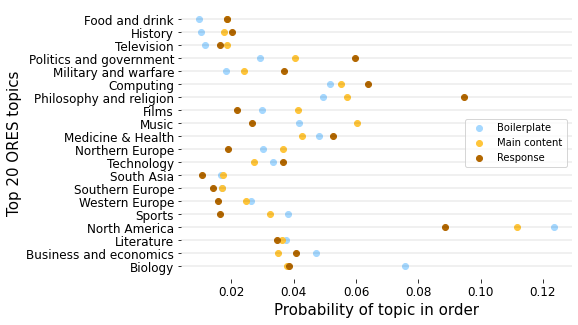

In [22]:
group = order_counts2.groupby("name_")

fig,ax=plt.subplots(figsize = (7,5))
for i,val in enumerate(topics):
    plt.axhline(i, 0,1,alpha = 0.4, linewidth = 0.3, color = "k")

for c, (name, g) in zip(colors,group):
    plt.scatter(g.p,g.topic_leaf,label = f"{name}", color = c)
#     plt.scatter(g.values,web_mean.index, label = "Web", color = "#C49799")

plt.tick_params(labelsize = 12)
plt.legend(frameon = True, loc = "lower right", fontsize = 13)
plt.xlabel("Probability of topic in order", fontsize = 15)
plt.ylabel("Top 20 ORES topics", fontsize = 15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.legend(bbox_to_anchor=(1, .5))
ax.legend(loc = "center right")

plt.savefig("/scratch/venia/web2wiki/visuals/where_and_what.pdf",dpi = 300, bbox_inches="tight")

In [23]:
wiki_scores = pd.read_csv("/scratch/venia/web2wiki/data/homepage2vec/10k_wiki.csv",names = ["domain","scores"])


In [24]:
orders_and_domain = df2.groupby("order")["order","domain"].sample(1000)

/tmp/ipykernel_857184/3735457340.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  orders_and_domain = df2.groupby("order")["order","domain"].sample(1000)


In [198]:
from homepage2vec.model import WebsiteClassifier


/home/veselovs/miniconda3/lib/python3.9/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(
2022-10-12 22:14:58.109434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-12 22:14:58.109466: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [199]:
model = WebsiteClassifier(cpu_threads_count=20, dataloader_workers=20)


In [200]:
def get_scores(domain):
    try:
        website = model.fetch_website(domain)
        scores, embeddings = model.predict(website)
    except:
        scores = None
    return (domain,scores)


def process_samples(df):
    scores_list = []
    for i, value in df.iterrows():
        domain = value["domain"]
        scores_list.append(get_scores(domain))
    return scores_list
        

In [201]:
sample_wiki = process_samples(orders_and_domain)


/home/veselovs/miniconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:621: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


In [209]:
tt = pd.DataFrame(sample_wiki, columns = ["domain", "scores"])
ttt = tt.merge(orders_and_domain, on = "domain", how = "left")

In [216]:
ttt=ttt.drop_duplicates(subset = ["domain","order"]).dropna()

In [218]:
ttt.to_csv("/scratch/venia/web2wiki/data/where_where.csv", index=False)

In [66]:
ttt = pd.read_csv("/scratch/venia/web2wiki/data/where_where.csv")

In [68]:
ttt["scores"] = ttt["scores"].apply(lambda x: eval(x))

In [69]:
scores = ttt["scores"].apply(pd.Series)

In [70]:
ttt2 = ttt.merge(p, on = "order")

In [71]:
scores["name"] = ttt2["name_"]
scores["domain"] = ttt2["domain"]

In [73]:
scores2 = scores.drop(columns="domain").groupby("name").mean()

In [74]:
scores2 = scores2[scores2.columns[-1::-1]]

In [75]:
scores2.columns = [k.replace("_", " ") for k in scores2.columns]

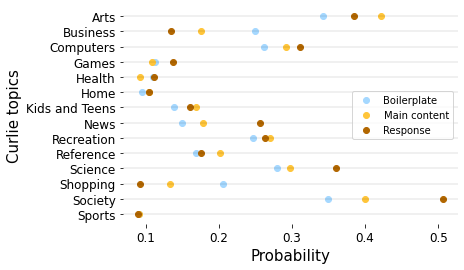

In [76]:

fig,ax=plt.subplots()
for i,val in enumerate(scores2.columns):
    plt.axhline(i, 0,1,alpha = 0.4, linewidth = 0.3, color = "k")

for c, (name, g) in zip(colors, scores2.iterrows()):
    plt.scatter(g.values,g.index,label = f"{name}", color = c)
#     plt.scatter(g.values,web_mean.index, label = "Web", color = "#C49799")

plt.tick_params(labelsize = 12)
plt.legend(frameon = True, loc = "lower right", fontsize = 13)
plt.xlabel("Probability", fontsize = 15)
plt.ylabel("Curlie topics", fontsize = 15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.legend(bbox_to_anchor=(1, .5))
ax.legend(loc = "center right")

plt.savefig("/scratch/venia/web2wiki/visuals/where_and_where.pdf",dpi = 300, bbox_inches="tight")